# Set Configuration Object

In [16]:
from utils.utils import get_device, make_dir, save_img
import torch

In [17]:
config = {
    "NSIDE" : 8,
    "SHOW_IMAGES" : True,
    "RECT" : True,
    "DEPTH" : 4,
    
    "train_pct": 0.7,
    "val_pct": 0.15,

    "BATCH_SIZE": 16,
    "EPOCHS": 500,
    "PATIENCE": 25, 
    "LEARNING_RATE": 0.01,

    "base": torch.float32,
    "device": get_device()
}

config["NUMPIX"] = 12 * config["NSIDE"] ** 2

In [18]:
from src.utils import set_seed
set_seed(2021)

# Load in Data and create DataLoader

In [19]:
import pickle
import numpy as np

from torch.utils.data import Dataset, DataLoader, TensorDataset
from data_loader.HealpixDataLoader import HealpixDataLoader

In [20]:
NSIDE = config["NSIDE"]

file_name = f"split_sphere_datasets_NSIDE{NSIDE}.pkl"

length = 32 * NSIDE // 8
width = 24 * NSIDE // 8
depth = 4

output_dim = (depth, width, length)

BATCH_SIZE = 16
SHUFFLE = True

healpix_loader = HealpixDataLoader(file_name, output_dim, config, SHUFFLE)

train_loader, val_loader, test_loader = healpix_loader.get_loaders()

# Pass in Model Architecture

In [21]:
from model.ConvExpand import ConvExpand

In [22]:
from torch.nn import Module, Conv2d, Sequential, ConvTranspose2d, ReLU, MaxPool2d, Linear, Conv3d, Tanh, Dropout

# IMPORTANT: change linear layer output to batch size * 256 so dimensions match? hmm
lin8 = Sequential (
   Linear(2, 12),
   ReLU(),
   Linear(12, 384),
   ReLU(),
   Linear(384, 3072),
)


mid_rect_size = (width, length)

conv8 = Sequential (
   Conv2d(4, 16, kernel_size=3, padding=1, padding_mode="reflect"),
   ReLU(),
   Conv2d(16, 4, kernel_size=3, padding=1, padding_mode="reflect"),
)


expand8 = ConvExpand(lin8, conv8, mid_rect_size, config)

In [23]:
model = expand8

# Create Trainer

In [24]:
import torch.optim as optim
from torch.nn import MSELoss

# Use MSE Loss
# need to specify cpu
criterion = MSELoss().to(dtype=config["base"], device=config["device"])

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
from trainer.trainer import Trainer

In [26]:
trainer = Trainer(model, criterion, optimizer, config, train_loader, val_loader)

# Train Model

In [27]:
trainer.train()

Epoch 1 of 500, Train Loss: 0.4251749802326208, Val Loss: 0.31719609085434036
Epoch 2 of 500, Train Loss: 0.2747735695163437, Val Loss: 0.2799628612855358
Epoch 3 of 500, Train Loss: 0.20009161457055447, Val Loss: 0.1700028667426653
Epoch 4 of 500, Train Loss: 0.16861946301616662, Val Loss: 0.16250751567974153
Epoch 5 of 500, Train Loss: 0.13226969263517016, Val Loss: 0.147487684890191
Epoch 6 of 500, Train Loss: 0.12586003535707266, Val Loss: 0.1305078303969256
Epoch 7 of 500, Train Loss: 0.11490713492483004, Val Loss: 0.11803321156905607
Epoch 8 of 500, Train Loss: 0.10954350163407535, Val Loss: 0.08723680000351772
Epoch 9 of 500, Train Loss: 0.07694695972098559, Val Loss: 0.09042175133570009
Epoch 10 of 500, Train Loss: 0.047958654896807854, Val Loss: 0.034200370675771946
Epoch 11 of 500, Train Loss: 0.03380860004831425, Val Loss: 0.031193470837190408
Epoch 12 of 500, Train Loss: 0.02287945840884694, Val Loss: 0.022752409564264435
Epoch 13 of 500, Train Loss: 0.02090415014740436, Va

KeyboardInterrupt: 

# Loss Graphs

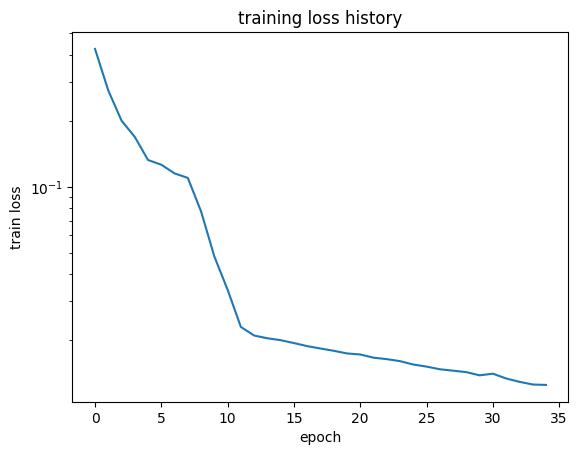

In [28]:
import matplotlib.pyplot as plt

plt.title("training loss history")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.yscale("log")
plt.plot(trainer.train_loss_hist)

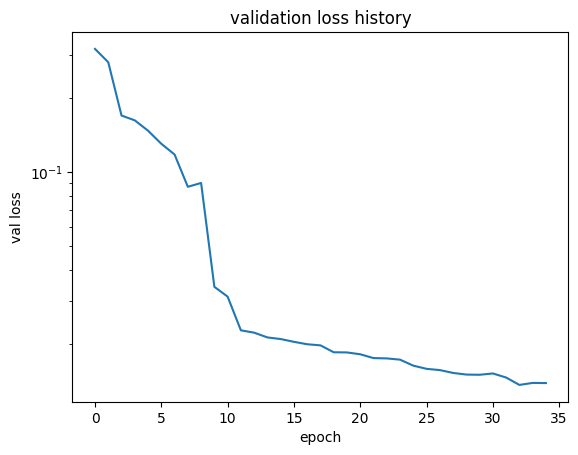

In [31]:
plt.title("validation loss history")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.yscale("log")
plt.plot(trainer.val_loss_hist)

# Show a sample output

0.06330205


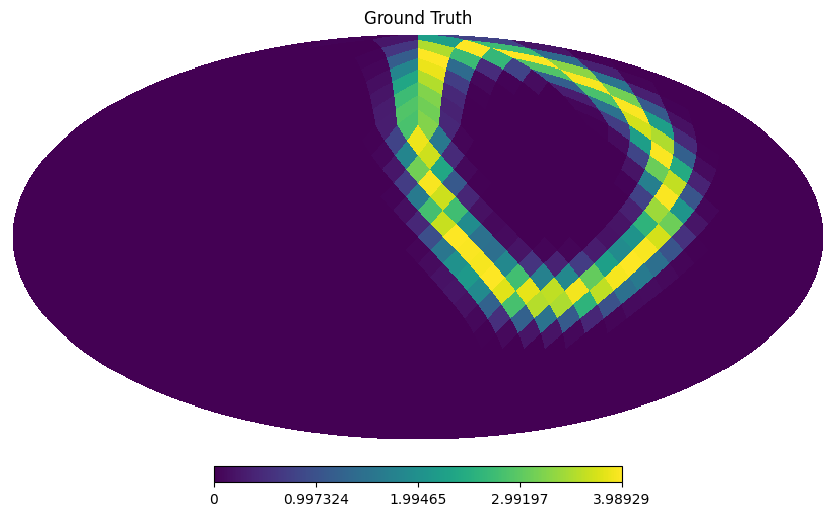

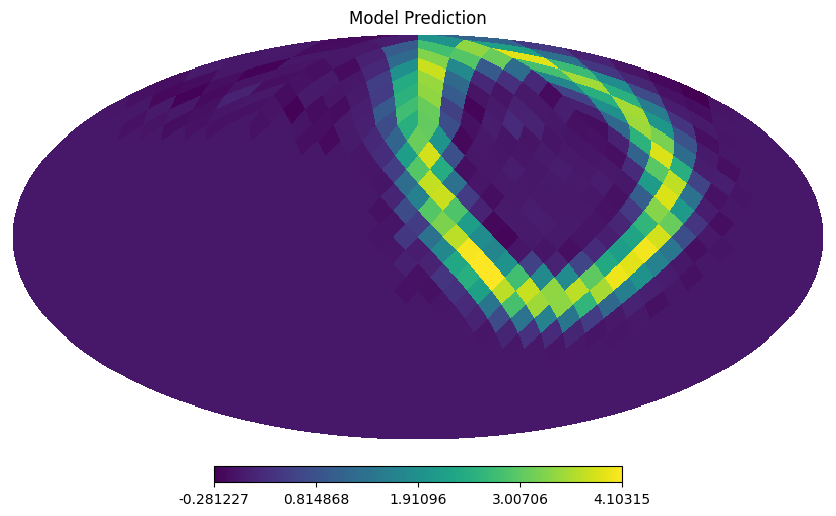

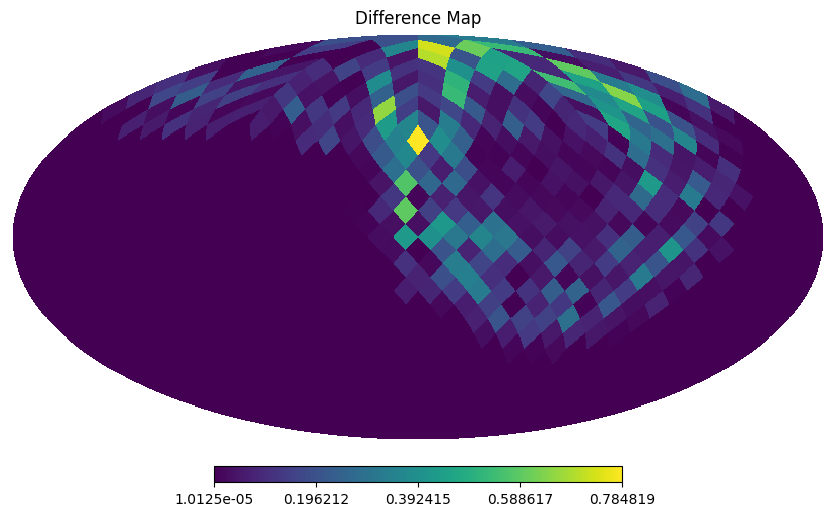

In [50]:
import healpy as hp

def display_sample(model, data_loader, config):
    for x, y in data_loader:
        # Set model to evaluation mode to conserve memory 
        model.eval()

        # Don't want to waste memory on gradients
        with torch.no_grad():

            pred = model(x)

            truth = torch.reshape(y[0], (config["DEPTH"], config["NUMPIX"], ))[3].detach().numpy()
            model_pred = np.reshape(pred[0].detach().numpy(), (config["DEPTH"], config["NUMPIX"], ))[3]

            diff = np.absolute(model_pred - truth)
            
            hp.mollview(truth, title="Ground Truth", nlocs=5)

            hp.mollview(model_pred, title="Model Prediction", nlocs=5)

            hp.mollview(diff, title="Difference Map", nlocs=5)

            print(np.mean(diff))

            # set back to train mode
            model.train()
            break
    

display_sample(model, val_loader, config)

## Create Dataloader of Model Outputs 

In [ ]:
def save_model_outputs(model, path):
    preds = []
    truths = []

    for x, y in val_loader:
    # Set model to evaluation mode to conserve memory 
        model.eval()

        # Don't want to waste memory on gradients
        with torch.no_grad():

            pred = model(x)

            pred_np = pred.detach().numpy()
            truth_np = y.detach().numpy()

            new_shape = (4, 12, 64)

            # batched right now, so need to unbatch 
            for i in range(len(pred_np)):

                # need to also reshape each element
                pred_reshape = np.reshape(pred_np[i], new_shape)
                truth_reshape = np.reshape(truth_np[i], new_shape)

                print(pred_reshape.shape)

                # need to add each depth individually
                for depth in range(4):
                    # [0] since first 1 dimension
                    preds.append(pred_reshape[depth])
                    truths.append(truth_reshape[depth])
    
    preds = np.array(preds)
    truths = np.array(truths)

    print(preds.shape)
            
    combined_set = TensorDataset(torch.tensor(preds).to(dtype=base, device=device), torch.tensor(truths).to(dtype=base, device=device))
    loader = DataLoader(combined_set, 1, shuffle=True)
    
    torch.save(loader, path)

    # set back to train mode
    model.train()

final_train_loss = round(float(train_loss_hist[-1]), 3)
final_val_loss = round(float(val_loss_hist[-1]), 3)

name = f"saved-pred-outputs/output-loader-model_NSIDE{NSIDE}_trainloss{final_train_loss}_valloss{final_val_loss}_epochs{epoch}.pth"
save_model_outputs(model, name)